## DQN
### 问题定义
倒立摆控制环境
Cart Pole即车杆游戏，游戏模型如下图所示。游戏里面有一个小车，上有竖着一根杆子，每次重置后的初始状态会有所不同。小车需要左右移动来保持杆子竖直，为了保证游戏继续进行需要满足以下两个条件：

杆子倾斜的角度$\theta$不能大于15°

小车移动的位置$x$需保持在一定范围（中间到两边各2.4个单位长度）

动作（action）：
- 左移（0）
- 右移（1）

状态变量（state variables）：
- $x$ ：小车在轨道上的位置（position of the cart on the track）
- $\theta$ ：杆子与竖直方向的夹角（angle of the pole with the vertical）
- $\dot{x}$ ：小车速度（cart velocity）
- $\dot{\theta}$ ：角度变化率（rate of change of the angle）

游戏奖励（reward）：

在gym的Cart Pole环境（env）里面，左移或者右移小车的action之后，env会返回一个+1的reward。其中CartPole-v0中到达200个reward之后，游戏也会结束，而CartPole-v1中则为500。最大奖励（reward）阈值可通过前面介绍的注册表进行修改。


In [1]:
import random
import gym
import numpy as np
import torch
from RL_algo.model_free.value_based import TD_learning_fun as TD
import warnings
warnings.filterwarnings("ignore")

#### 模型参数

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env = gym.make('CartPole-v0')
random.seed(0)
np.random.seed(0)
env.reset(seed = 0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

#### DQN算法调用

Iteration 9: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s, episode=500, return=187.900]


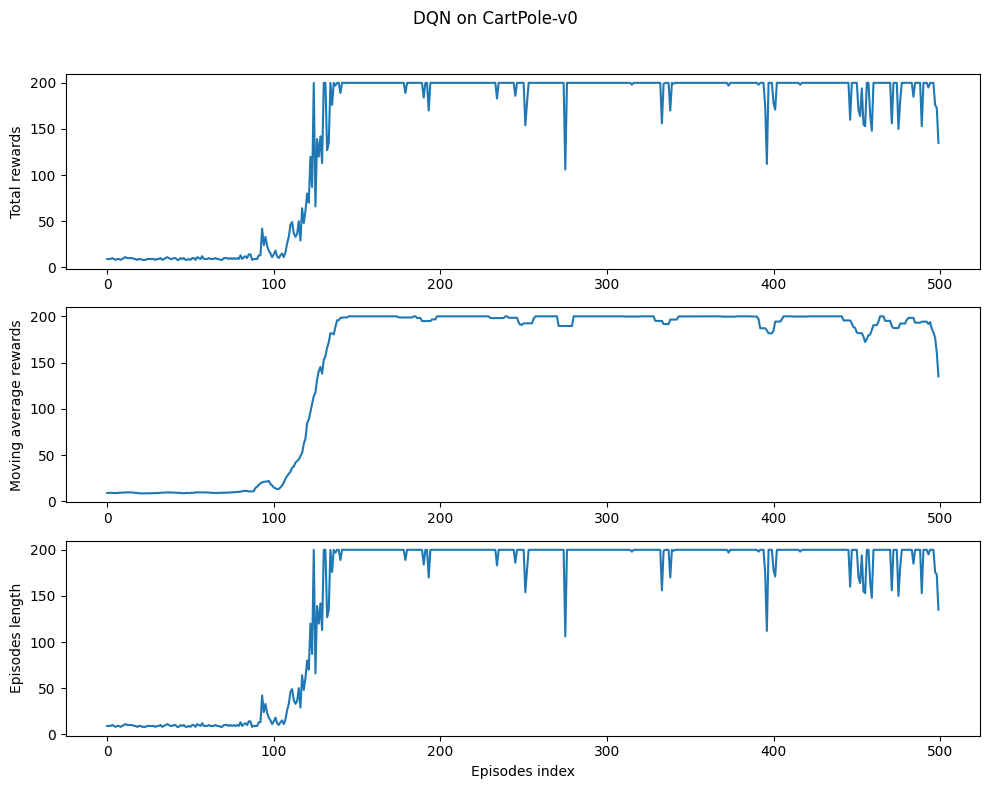

In [3]:
lr = 2e-3
hidden_dim =[128]
gamma = 0.98
epsilon = 0.01
target_update = 20#更新频率越大好像可以增加平稳性，但是会减少收敛速度
num_episodes = 500
buffer_size = 10000
minimal_size = 500
batch_size = 64
agent = TD.DQN(state_dim, action_dim, hidden_dim, lr, gamma, epsilon, target_update, device, env)
agent.run_DQN(buffer_size,num_episodes,minimal_size,batch_size)


#### 运行训练好的智能体并可视化展示

In [4]:
def run_trained_agent(env, agent, num_episodes=5):
    for i in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            env.render() 
            action = agent.best_action(state)  # 使用训练好的智能体选择动作
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        print(f"Episode {i + 1}: Total Reward: {total_reward}")
    env.close()

run_trained_agent(env, agent)

Episode 1: Total Reward: 200.0
Episode 2: Total Reward: 200.0
Episode 3: Total Reward: 200.0
Episode 4: Total Reward: 186.0
Episode 5: Total Reward: 200.0


## Double DQN
### 环境定义

1. 概述
倒立摆问题是控制文献中的经典问题。 在这个版本的问题中，钟摆以随机位置开始，目标是将其向上摆动，使其保持直立。

    类型：连续控制

2. 环境
   
    2.1 Observation & state

   | $n$|  Observation  | $Min$ | $Max$ |
   |----|---------------|-------|-------|
   | 0  | $cos(\theta)$ |  -1.0 |  1.0  |
   | 1  | $sin(\theta)$ |  -1.0 |  1.0  |
   | 2  | $\dot{\theta}$|  -8.0 |  8.0  |


    state是最原始的环境内部的表示，observation则是state的函数。好比我们所看见的东西并不一定就是它们在世界中的真实状态，而是经过我们的大脑加工过的信息

    2.2 Actions
   | $n$|      Action   | $Min$ | $Max$ |
   |----|---------------|-------|-------|
   | 0  |      力矩      |  -2.0 |  2.0  |

   2.3 Reward
   奖励的精确等式：
    $-(\theta^2 + 0.1\dot{\theta}^2 + 0.001action^2)$

   $\theta$在 $-\pi$ 和 $\pi$ 之间归一化。因此，
   最小代价是-16.2736044，
   最高代价为0。
   实质上，目标是保持零角度（垂直），旋转速度最小，力度最小。

   2.4 初始状态
   从和的随机角度，以及-1和1之间的随机速度

   2.5 终止状态- Episode Termination
   没有指定的终止状态。 添加最大步数可能是个好主意。

   2.6 Solved Requirements
   目前尚未指定


#### 模型参数

In [5]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作

Iteration 9: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=500, return=-200.711]


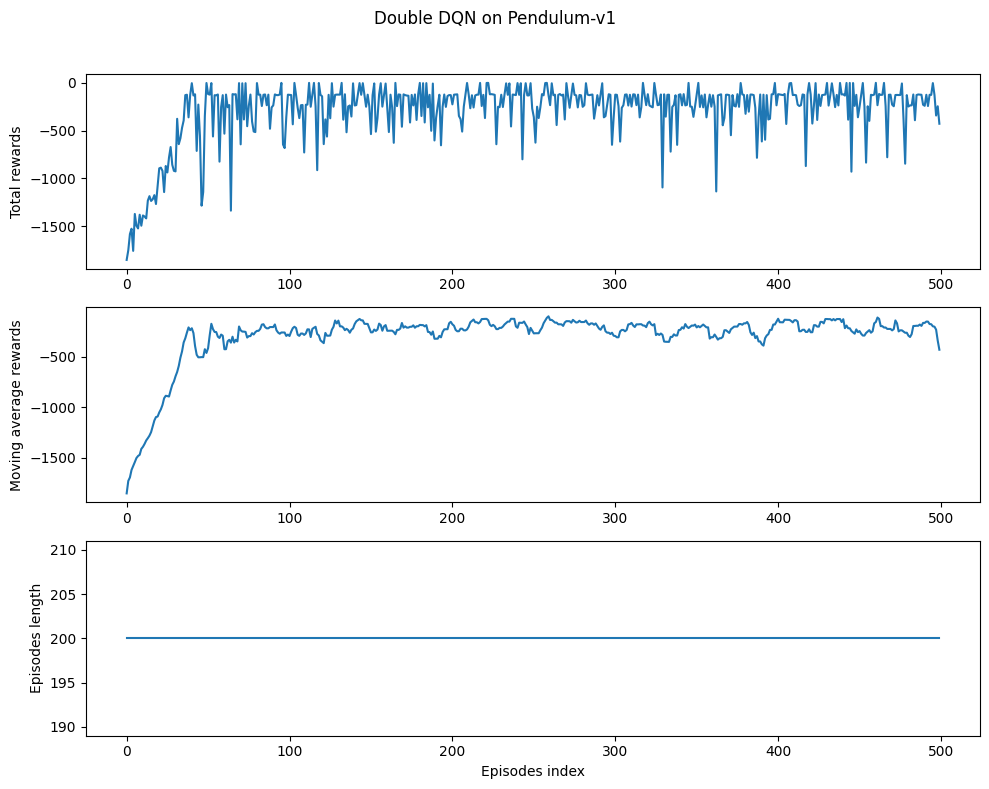

In [6]:
lr = 1e-2
num_episodes = 500
hidden_dim = [128]
gamma = 0.98
epsilon = 0.01
target_update = 80
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
agent = TD.Double_DQN(state_dim, action_dim, hidden_dim, lr, gamma, epsilon, target_update, device, env)

agent.run_Double_DQN(buffer_size,num_episodes,minimal_size,batch_size)

In [7]:
run_trained_agent(env, agent)

Episode 1: Total Reward: -1.4736721042973493
Episode 2: Total Reward: -128.0677271202858
Episode 3: Total Reward: -505.3385356673842
Episode 4: Total Reward: -233.9756595322963
Episode 5: Total Reward: -223.62283565907597


#### Dueling DQN

Iteration 9: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s, episode=500, return=-183.178]


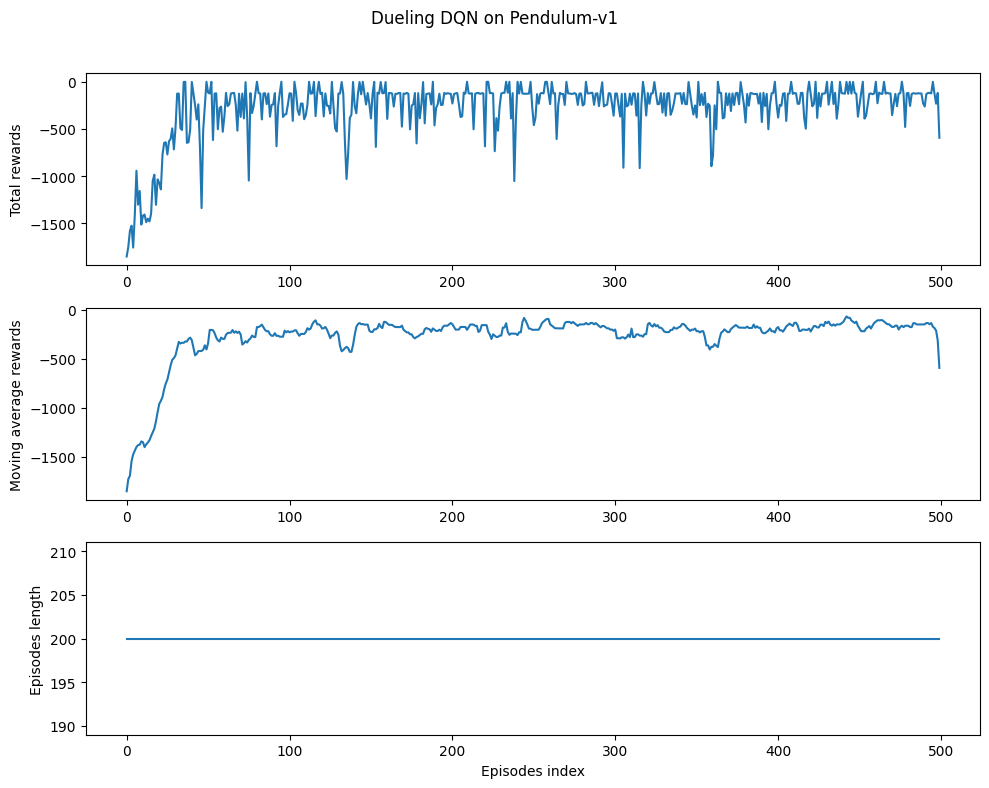

In [8]:
lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 80
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
agent = TD.Dueling_DQN(state_dim, action_dim, hidden_dim, lr, gamma, epsilon, target_update, device, env)

agent.run_Dueling_DQN(buffer_size,num_episodes,minimal_size,batch_size)